<h1 align='center'> Análise Modal de um Modelo Quarter-Car </h1>

In [1]:
#Importando bibliotecas:
import numpy as np
from sympy import *
from sympy.integrals.heurisch import heurisch
import warnings
import matplotlib.pyplot as plt
import scienceplots

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])

title = True

#Exibição dos gráficos em no notebook:
%matplotlib inline

'''
#Exibição dos gráficos em janela externa:
%matplotlib qt
'''

# Inicializações importantes:
warnings.filterwarnings("ignore")
init_printing()

# Função de arredondar elemento da matriz:
def arredNUM(matrix):
    for a in preorder_traversal(matrix):
        if isinstance(a, Float):
            matrix = matrix.subs(a, round(a, 4))
    return matrix

<div align="center">
    <img src="images/hcpmodel1.png">
    <img src="images/hcpmodel2.png">
</div>

<h5 align='right'> (Jazar, 2017) - 3rd ed </h5>

$$[M]\ddot{[X]} + [C]\dot{[X]} + [K][X] = [F]$$

<h5 align='right'> Jazar - Eq. (11.46) </h5>

### Parâmetros do sistema:

In [2]:
# Unidades no S.I [m, Kg, N/m, Kg*m², (N*s)/m]:
# GDL não suspenso dianteiro:
a1 = 1.4
m1 = 53
kt1 = 200000

# GDL não suspenso traseiro:
a2 = 1.47
m2 = (152/2)
kt2 = 200000

# GDL suspenso:
Iy = (1100/2)
ms = (840/2)
k1 = 10000
k2 = 13000
c1 = 1800
c2 = 2000

### Excitação externa por perfil de pista:

##### Entrada Harmônica:

In [3]:


# Tempo de amostragem:
ts = 1e-2

# Tempo de simulação:
tf = 80

# Velocidade do carro em Km/h:
v_car = 18

# Amplitude em mm:
amplitude = 250

# Espaçamento em m:
esp = 100

# Offset em mm:
offset = 0

# Função de entrada de deslocamento, em mm:
x = Symbol('x')
freq = round(((v_car*2*np.pi)/(3.6*esp)), 4)

phi_t = round(((a1+a2)/v_car), 4)
phi_d = 0

ent_t = (((amplitude*sin((x*freq)+phi_t))+offset)*1e-3)
ent_d = (((amplitude*sin((x*freq)+phi_d))+offset)*1e-3)

# Criação do vetor de tempo:
tfa = 500
if (tf > tfa):
    tfa = tf
time = np.arange(0, tfa, ts)

yt = lambdify(x, ent_t, 'numpy')(time)  # visualização do perfil
yd = lambdify(x, ent_d, 'numpy')(time)  # visualização do perfil

ent_t

##### Dados empíricos:

In [4]:


'''
# Leitura do arquivo:
ts = 1e-2
arq = open('data.txt', 'r')
g = []
for linha in arq:
    linha = arq.readline()
    if(linha != ''):
        g.append(float(linha))
arq.close()
def actopos(dados):
    v_ant = 0
    current_t = [0]
    current_pos = [0]
    for i in range(len(dados)):
        current_pos.append(round((current_pos[i]+(v_ant*ts)+(dados[i]*(ts**2))), 4))
        current_t.append(ts*(i+1))
    return current_t, current_pos
time, y = actopos(np.multiply(g, (9.8067*1e3)))
tf = np.max(time)
'''

# INCOMLPETO! - Tem que encontrar uma forma de ajustar uma função que atenda sinais senoidais, como soma de senos e cossenos a partir de uma amostra....

"\n# Leitura do arquivo:\nts = 1e-2\narq = open('data.txt', 'r')\ng = []\nfor linha in arq:\n    linha = arq.readline()\n    if(linha != ''):\n        g.append(float(linha))\narq.close()\ndef actopos(dados):\n    v_ant = 0\n    current_t = [0]\n    current_pos = [0]\n    for i in range(len(dados)):\n        current_pos.append(round((current_pos[i]+(v_ant*ts)+(dados[i]*(ts**2))), 4))\n        current_t.append(ts*(i+1))\n    return current_t, current_pos\ntime, y = actopos(np.multiply(g, (9.8067*1e3)))\ntf = np.max(time)\n"

##### Plot da superfície:

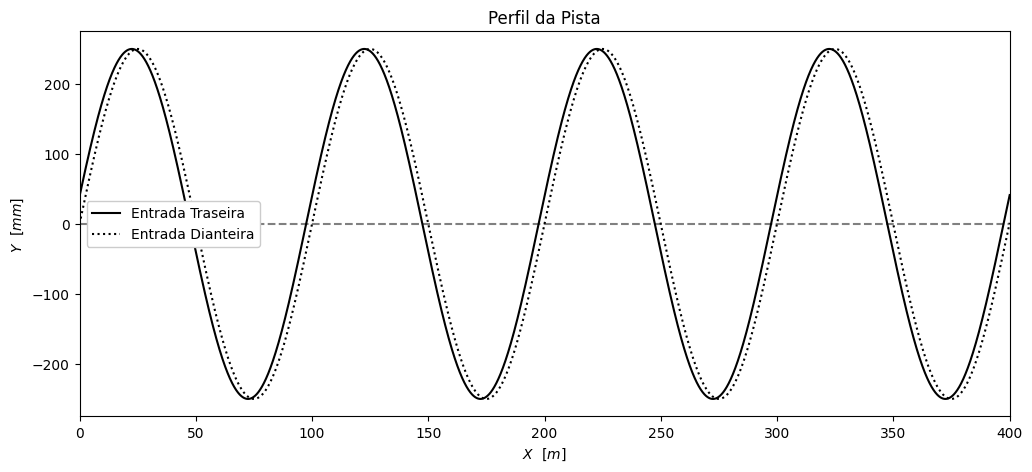

In [5]:
# Plotando os gráficos:
plt.rcParams['figure.figsize'] = (12, 5)
plt.figure()
plt.plot((0, (tf*v_car/3.6)), (0, 0), 'gray', linestyle='dashed')
plt.plot((time*v_car/3.6), (yt*1e3), 'k', label='Entrada Traseira')
plt.plot((time*v_car/3.6), (yd*1e3), 'k', linestyle='dotted', label='Entrada Dianteira')
plt.ylabel('$Y~~[mm]$')
plt.xlabel('$X~~[m]$')
plt.xlim(0, (tf*v_car/3.6))
plt.legend()
if(title):
    plt.title('Perfil da Pista')
plt.grid()
plt.savefig('curves/road_MA.eps', dpi=600, transparent=True, bbox_inches='tight')

### Definição das matrizes (Lagrange) e condições iniciais:

In [6]:
# Fator de correção para cálculos:
fc = 1e-3

# Matriz das massas (Kg):
M = np.array([
    [ms, 0, 0, 0],
    [0, Iy, 0, 0],
    [0, 0, m1, 0],
    [0, 0, 0, m2]
], dtype=float)*fc

# Matriz de rigidez (N/m):
K = np.array([
    [(k1+k2), ((a2*k2)-(a1*k1)), -k1, -k2],
    [((a2*k2)-(a1*k1)), ((k1*(a1**2))+(k2*(a2**2))), (a1*k1), -(a2*k2)],
    [-k1, (a1*k1), (k1+kt1), 0],
    [-k2, -(a2*k2), 0, (k2+kt2)]
], dtype=float)*fc

# Matriz de amortecimento (N*s/m):
C = np.array([
    [(c1+c2), ((a2*c2)-(a1*c1)), -c1, -c2],
    [((a2*c2)-(a1*c1)), ((c1*(a1**2))+(c2*(a2**2))), (a1*c1), -(a2*c2)],
    [-c1, (a1*c1), c1, 0],
    [-c2, -(a2*c2), 0, c2]
], dtype=float)*fc

# Matriz de F(x) (transposta):
F = np.array([0, 0, (ent_d*kt1), (ent_t*kt2)]).T*fc

# Matriz de posições iniciais (transposta):
X0 = np.array([0, 0, 0, 0], dtype=float).T

# Matriz de velocidades iniciais (transposta):
V0 = np.array([0, 0, 0, 0], dtype=float).T

Matrix(F)

⎡             0             ⎤
⎢                           ⎥
⎢             0             ⎥
⎢                           ⎥
⎢    50.0⋅sin(0.3142⋅x)     ⎥
⎢                           ⎥
⎣50.0⋅sin(0.3142⋅x + 0.1594)⎦

### $$\text{Obtenção de } [M]^{-1/2}:$$

In [7]:
MM = np.power(M, -1/2)  # Inverso da raíz quadrada

MM[MM == np.inf] = 0  # Transforma os elementos infinitos em zero

Matrix(MM.round(4))

⎡1.543    0       0       0   ⎤
⎢                             ⎥
⎢  0    1.3484    0       0   ⎥
⎢                             ⎥
⎢  0      0     4.3437    0   ⎥
⎢                             ⎥
⎣  0      0       0     3.6274⎦

### $$ \text{Cálculo da matriz } \tilde{[K]} = [M^{-1/2}][K][M^{-1/2}]:$$

In [8]:
K_til = MM@K@MM  # Cálculo da matriz K_til

Matrix(K_til.round(4))

⎡54.7619    10.632   -67.0251   -72.7632 ⎤
⎢                                        ⎥
⎢ 10.632   86.7122    81.999    -93.4701 ⎥
⎢                                        ⎥
⎢-67.0251   81.999   3962.2642      0    ⎥
⎢                                        ⎥
⎣-72.7632  -93.4701      0      2802.6316⎦

### $$ \text{Cálculo da matriz } \tilde{[C]} = [M^{-1/2}][C][M^{-1/2}]:$$

In [9]:
try:
    C_til = MM@C@MM  # Cálculo da matriz C_til
except:
    C_til = np.zeros((len(M), len(M)))

Matrix(C_til.round(4))

⎡ 9.0476   0.8739   -12.0645  -11.1943⎤
⎢                                     ⎥
⎢ 0.8739   14.2724  14.7598    -14.38 ⎥
⎢                                     ⎥
⎢-12.0645  14.7598  33.9623      0    ⎥
⎢                                     ⎥
⎣-11.1943  -14.38      0      26.3158 ⎦

### $$\text{Obtendo os autovalores (} \lambda \text{) e autovetores normalizados (} P \text{) de }\tilde{[K]}:$$

In [10]:
# Obtenção dos autovalores e autovetores normalizados
lamb, P = np.linalg.eig(K_til)

##### $$\text{Matriz de autovalores }[\lambda]:$$

In [11]:
Matrix(lamb.round(4))

⎡3965.1394⎤
⎢         ⎥
⎢2807.7839⎥
⎢         ⎥
⎢ 48.9104 ⎥
⎢         ⎥
⎣ 84.5361 ⎦

##### $$\text{Matriz de autovetores normalizados }[P]:$$

In [12]:
Matrix(P.round(4))

⎡0.0171   -0.0266  0.9599  0.2786 ⎤
⎢                                 ⎥
⎢-0.0211  -0.0344  -0.279  0.9594 ⎥
⎢                                 ⎥
⎢-0.9996  0.0009   0.0223  -0.0155⎥
⎢                                 ⎥
⎣0.0006   0.9991   0.0159  0.0405 ⎦

### Cálculo das frequências naturais: $$[\omega_n] = \left[ \sqrt{\lambda} \right]$$

In [13]:
omega_n = np.sqrt(lamb)  # Calcula a matriz de freqências naturais, em rad/s

Matrix(omega_n.round(4))

⎡62.9694⎤
⎢       ⎥
⎢52.9885⎥
⎢       ⎥
⎢6.9936 ⎥
⎢       ⎥
⎣9.1943 ⎦

### Mode Shapes: $$[u_i] = [M^{-1/2}][P_i]$$

In [14]:
U = (MM@P)  # Modos de vibrar: cada linha é um GDL e cada coluna representa um modo de vibrar

Matrix(U.round(4))

⎡0.0263   -0.041   1.4811   0.4299 ⎤
⎢                                  ⎥
⎢-0.0285  -0.0464  -0.3762  1.2937 ⎥
⎢                                  ⎥
⎢-4.3421  0.0039   0.0968   -0.0672⎥
⎢                                  ⎥
⎣0.0023    3.624   0.0576   0.1467 ⎦

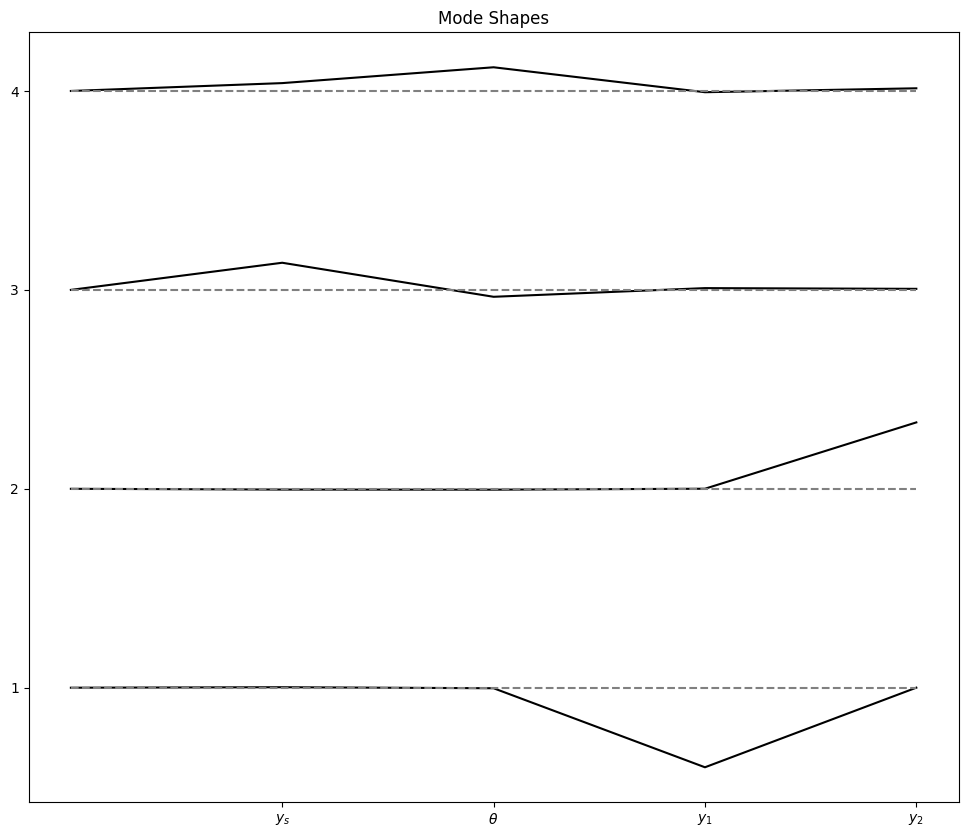

In [15]:
horizontal = False  # Define o sentido de variação dos GDL's

# Plotando os gráficos:
plt.rcParams['figure.figsize'] = (12, 10)
plt.figure()

space = (np.max(np.abs(U))*2.5)

padding = []
for i in range(len(U)+1):
    padding.append(space*i)

vib = []
for i in range(len(U)):
    vib.append([(space*(i+1))])

for i in range(len(vib)):
    vib[i] = np.concatenate((vib[i], (vib[i][0]+U.T[i])))

if (horizontal):
    for i in range(len(U)):
        plt.plot(vib[i], padding, 'k')
        plt.plot((vib[i][0], vib[i][0]), (0, (space*len(U))),
                 'gray', linestyle='dashed')
    plt.xticks(padding[1:], range(1, len(U)+1))
    labels = []
    for i in range(1, len(U)+1):
        labels.append(f'$y_{i}$')
    plt.yticks(padding[1:], labels)
else:
    for i in range(len(U)):
        plt.plot(padding, vib[i], 'k')
        plt.plot((0, (space*len(U))),
                 (vib[i][0], vib[i][0]), 'gray', linestyle='dashed')
    plt.yticks(padding[1:], range(1, len(U)+1))
    labels = ['$y_s$', '$\\theta$', '$y_1$', '$y_2$']
    plt.xticks(padding[1:], labels)

if(title):
    plt.title('Mode Shapes')
plt.grid()
plt.savefig('curves/mode_shapes.eps', dpi=600, transparent=True, bbox_inches='tight')

### $$\text{Cálculo da matriz } [S] = [M^{-1/2}][P]$$

In [16]:
S = MM@P  # Cálcula a matriz S

Matrix(S.round(4))

⎡0.0263   -0.041   1.4811   0.4299 ⎤
⎢                                  ⎥
⎢-0.0285  -0.0464  -0.3762  1.2937 ⎥
⎢                                  ⎥
⎢-4.3421  0.0039   0.0968   -0.0672⎥
⎢                                  ⎥
⎣0.0023    3.624   0.0576   0.1467 ⎦

### $$\text{Cálculo da matriz } [\Lambda] = [P^T][\tilde{K}][P]$$

In [17]:
# Calcula a matriz LAMBDA, que deve ser igual à matriz diagonal contendo os autovalores
LAMB = P.T@K_til@P

Matrix(LAMB.round(4))

⎡3965.1394      0         0        0   ⎤
⎢                                      ⎥
⎢    0      2807.7839     0        0   ⎥
⎢                                      ⎥
⎢    0          0      48.9104     0   ⎥
⎢                                      ⎥
⎣    0          0         0     84.5361⎦

### $$\text{Cálculo da matriz } [\Gamma] = [P^T][\tilde{C}][P]$$

In [18]:
GAM = P.T@C_til@P  # Calcula a matriz GAMMA, que deve ser igual à matriz diagonal contendo os coeficientes de amortecimento em r -> 2*zeta*omega

Matrix(GAM.round(4))

⎡34.9801    0.2917   15.1332  -10.5051⎤
⎢                                     ⎥
⎢ 0.2917    27.873   -6.4299  -16.3601⎥
⎢                                     ⎥
⎢15.1332   -6.4299   8.0892   -0.7169 ⎥
⎢                                     ⎥
⎣-10.5051  -16.3601  -0.7169  12.6557 ⎦

### $$\text{Determinando os coeficientes de amortecimento } \zeta_i:$$

In [19]:
try:
    Matrix(Z.round(4))
except:
    Z = np.zeros(len(M))
    for i in range(len(omega_n)):
        Z[i] = (GAM[i][i]/(2*np.sqrt(LAMB[i][i])))
Matrix(Z.round(4))

⎡0.2778⎤
⎢      ⎥
⎢0.263 ⎥
⎢      ⎥
⎢0.5783⎥
⎢      ⎥
⎣0.6882⎦

### Cálculo das frequências amortecidas: $$[\omega_d] = \left[ \omega_n\sqrt{1-\zeta^2} \right]$$

In [20]:
# Calcula a matriz de freqências amortecidas, em rad/s
omega_d = omega_n*np.sqrt(1-np.power(Z, 2))

Matrix(omega_d.round(4))

⎡60.4916⎤
⎢       ⎥
⎢51.123 ⎥
⎢       ⎥
⎢5.7054 ⎥
⎢       ⎥
⎣6.6704 ⎦

### $$\text{Cálculo da matriz } [\Pi] = [P^T][M^{-1/2}][F]$$

In [21]:
# Calcula a matriz PI, que deve ser igual à matriz coluna, contendo as componentes da força aplicada, distribuida nos GDL's
PI = Matrix(P.T@MM@F)

Matrix(arredNUM(PI))

⎡-217.1061⋅sin(0.3142⋅x) + 0.114⋅sin(0.3142⋅x + 0.1594)⎤
⎢                                                      ⎥
⎢0.1957⋅sin(0.3142⋅x) + 181.1977⋅sin(0.3142⋅x + 0.1594)⎥
⎢                                                      ⎥
⎢ 4.8404⋅sin(0.3142⋅x) + 2.8825⋅sin(0.3142⋅x + 0.1594) ⎥
⎢                                                      ⎥
⎣-3.3606⋅sin(0.3142⋅x) + 7.3365⋅sin(0.3142⋅x + 0.1594) ⎦

### Transformações de coordenadas das condições iniciais: $$[X_0], [V_0] ~~\rightarrow~~ [R_o], [\dot{R_0}]$$

##### $$\text{Matriz de posição }[X_0] \rightarrow [R_0]:$$

In [22]:
R0 = np.linalg.inv(S)@X0  # Conversão de coordenadas para posição

Matrix(R0.round(4))

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

##### $$\text{Matriz de velocidade }[V_0] \rightarrow [\dot{R_0}]:$$

In [23]:
RD0 = np.linalg.inv(S)@V0  # Conversão de coordenadas para velocidade

Matrix(RD0.round(4))

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

### Obter soluções modais desacopladas do tipo: $$r_i(t) = A_ie^{-\zeta_i\omega_it}sen(\omega_{d_i}t+\phi_i)+\frac{1}{m_i\omega_{d_i}}e^{-\zeta_i\omega_it}\int_0^t \left( f_i(\tau)e^{\zeta_i\omega_i\tau}sen(\omega_{d_i}(t-\tau)) \right)d\tau$$

### $$\text{Cálculo de } A_i = \sqrt{\frac{(r_{0_i}\omega_{d_i})^2+(\dot{r_{0_i}}+\zeta_i\omega_ir_{0_i})^2}{\omega_{d_i}^2}}:$$

In [24]:
A = np.sqrt((np.power((R0*omega_n), 2)+np.power((RD0+(Z*omega_n*R0)), 2))/np.power(omega_d, 2))  # Cálculo da matriz de amplitudes

Matrix(A.round(4))

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

### $$\text{Cálculo de } \phi_i = tan^{-1}\left( \frac{r_{o_i}\omega_{d_i}}{\dot{r_0}_i+\zeta_i\omega_ir_{0_i}} \right):$$

In [25]:
# Cálculo da matriz de fases, em radianos
ph = np.arctan((R0*omega_n)/(RD0+(Z*omega_n*R0)))

PHI = []

# Ajuste para evitar erros de aproximação do ponto flutuante e indefinições de atan():
for i in range(len(ph)):
    if (RD0[i]+(Z[i]*omega_n[i]*R0[i])):
        if ((ph[i]/np.pi) in (0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0)):
            PHI.append(nsimplify(round((ph[i]/np.pi), 4)*pi))
        else:
            PHI.append(round(ph[i], 4))
    elif (R0[i]*omega_n[i]):
        PHI.append(pi/2)
    else:
        PHI.append(0)

Matrix(PHI)

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

### Montando as expressões:

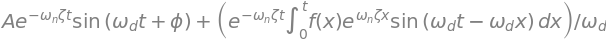

In [26]:
# Definição da forma geral da solução:
a = Symbol('A')
omgn = Symbol('\omega_n')
omgd = Symbol('\omega_d')
phi = Symbol('\phi')
f = Function('f')(x)
z = Symbol('\zeta')
t = Symbol('t')

# Resposta amortecida:
damped = (a*exp(-z*omgn*t)*sin((omgd*t)+phi))

# Método Heurístico para resolução da integral indefinida e teorema fundamental do cálculo:
def itg(fun, a, b):
    expression = heurisch(fun, x)
    return simplify(expression.subs(x, b) - expression.subs(x, a))

# Resposta forçada:
def forced(function=None):
    if (function == None):
        return ((1/omgd)*exp(-z*omgn*t)*integrate((f*exp(z*omgn*x)*sin(omgd*t-omgd*x)), (x, 0, t)))
    else:
        return ((1/omgd)*exp(-z*omgn*t)*itg((function*exp(z*omgn*x)*sin(omgd*t-omgd*x)).subs([(a, A[i]), (omgn, omega_n[i]), (phi, PHI[i]), (omgd, omega_d[i]), (z, Z[i])]), 0, t))


(damped+forced())

In [27]:
# Substituição das respectivas constantes em suas iterações:
RT = []
for i in range(len(omega_n)):
    ri = (damped+forced(PI[i])).subs([(a, A[i]), (omgn, omega_n[i]), (phi, PHI[i]), (omgd, omega_d[i]), (z, Z[i])]).doit()
    RT.append(trigsimp(arredNUM(ri)))  # Simplificação trigonométrica

Matrix(RT)

⎡       ⎛          17.49⋅t                         17.49⋅t                    
⎢0.0165⋅⎝- 3.3105⋅ℯ       ⋅sin(0.3142⋅t) + 0.0095⋅ℯ       ⋅cos(0.3142⋅t) + 0.0
⎢                                                                             
⎢       ⎛        13.9365⋅t                         13.9365⋅t                  
⎢0.0196⋅⎝3.2626⋅ℯ         ⋅sin(0.3142⋅t) + 0.5135⋅ℯ         ⋅cos(0.3142⋅t) - 0
⎢                                                                             
⎢       ⎛        4.0446⋅t                         4.0446⋅t                    
⎢0.1753⋅⎝0.8988⋅ℯ        ⋅sin(0.3142⋅t) + 0.0067⋅ℯ        ⋅cos(0.3142⋅t) - 0.0
⎢                                                                             
⎢        ⎛        6.3279⋅t                         6.3279⋅t                   
⎣ 0.1499⋅⎝0.3104⋅ℯ        ⋅sin(0.3142⋅t) + 0.0774⋅ℯ        ⋅cos(0.3142⋅t) - 0.

                                          ⎞  -17.49⋅t⎤
145⋅sin(60.4916⋅t) - 0.0095⋅cos(60.4916⋅t)⎠⋅ℯ        ⎥
                    

### Tempos de acomodação (critério 2%): $$ST = \frac{4}{\zeta\omega_n}$$

In [28]:
ultim_time = 0
for i in range(len(omega_n)):
    if (Z[i]):
        current = (4/(Z[i]*omega_n[i]))
        if (current > ultim_time):
            ultim_time = np.ceil(current*1.5)
        print(f'ST{i+1} = {round(current, 2)} s')
    else:
        print(f'ST{i+1} = {np.Infinity}')

ST1 = 0.23 s
ST2 = 0.29 s
ST3 = 0.99 s
ST4 = 0.63 s


### Respostas desacopladas:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


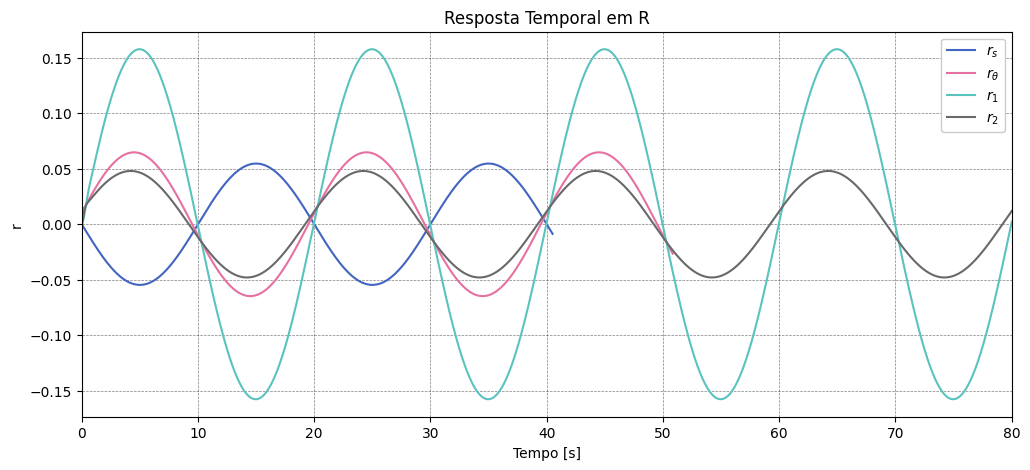

In [29]:
# Criando matriz de posição em função do tempo:
R = []
for i in RT:
    fx = lambdify(t, i, 'numpy')
    R.append(fx(time))

# Plotando os gráficos:
plt.rcParams['figure.figsize'] = (12, 5)
plt.figure()
labels = ['$r_s$', '$r_{\\theta}$', '$r_1$', '$r_2$']
for i in range(len(R)):
    plt.plot(time, R[i], label=labels[i])
plt.ylabel('r')
plt.legend()
plt.xlabel('Tempo [s]')
plt.xlim(0, tf)
if(title):
    plt.title('Resposta Temporal em R')

plt.savefig('curves/r_dom_TR.eps', dpi=600, transparent=True, bbox_inches='tight')

### Retornando ao domínio físico:

In [30]:
XT = arredNUM(trigsimp(Matrix(S@RT)))

Matrix(XT)

⎡                                                                        -13.9
⎢       0.249363242713815⋅sin(0.3142⋅t) + 0.0063⋅cos(0.3142⋅t) + 0.0001⋅ℯ     
⎢                                                                             
⎢                                                                             
⎢-0.000497066349589993⋅sin(0.3142⋅t) + 0.014086356684145⋅cos(0.3142⋅t) + 0.000
⎢                                                                             
⎢                                                                             
⎢  0.249536434914536⋅sin(0.3142⋅t) - 0.00130767955254115⋅cos(0.3142⋅t) - 0.001
⎢                                                                             
⎢                                                                             
⎣ 0.247525722648378⋅sin(0.3142⋅t) + 0.0382435214582815⋅cos(0.3142⋅t) - 0.0114⋅

365⋅t                         -13.9365⋅t                         -6.3279⋅t    
     ⋅sin(51.123⋅t) + 0.0004⋅ℯ          ⋅cos(51.123

### Resposta temporal:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


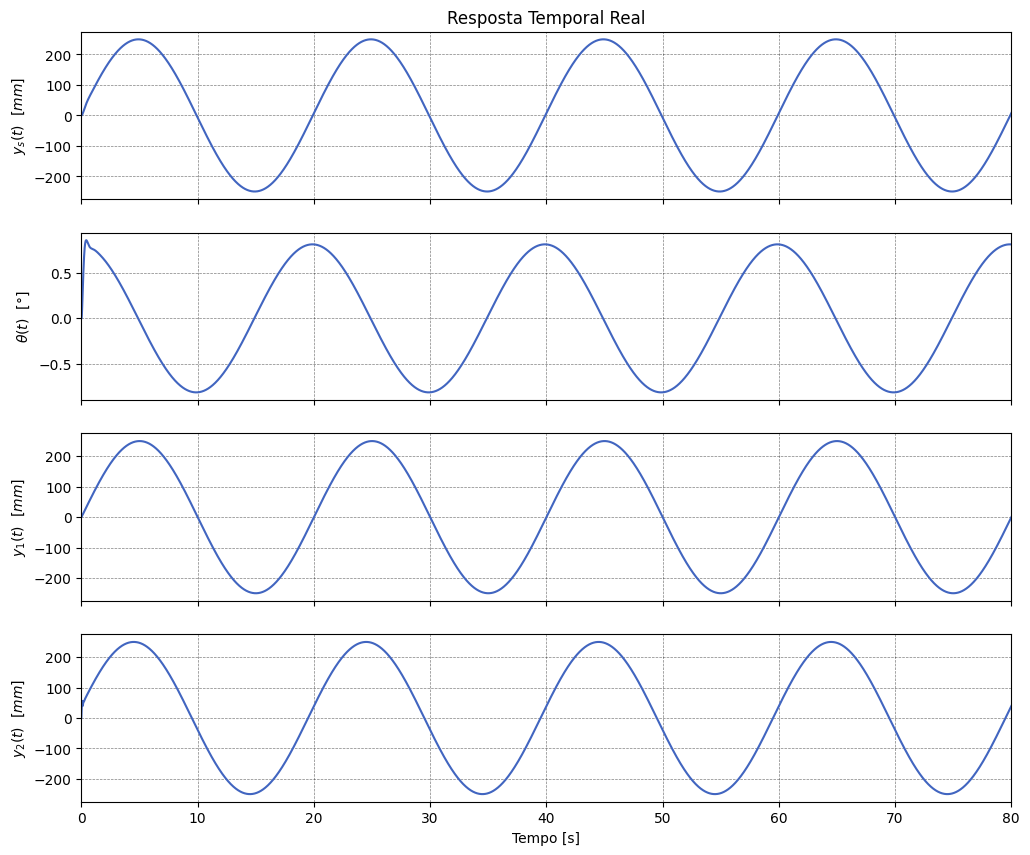

In [31]:
# Criando matriz de posição em função do tempo:
X = []
for i in XT:
    fx = lambdify(t, i, 'numpy')
    X.append(fx(time))

# Plotando os gráficos:
plt.rcParams['figure.figsize'] = (12, 10)
plt.subplots(len(X), sharex=True)
labels = ['$y_s(t)~~[mm]$', '$\\theta(t)~~[°]$', '$y_1(t)~~[mm]$', '$y_2(t)~~[mm]$']
for i in range(len(X)):
    plt.subplot(len(X), 1, (i+1))
    if(i==1):
        plt.plot(time, np.degrees(X[i]))
    else:
        plt.plot(time, (X[i]*1e3))
    plt.ylabel(labels[i])
plt.xlim(0, tf)
plt.xlabel('Tempo [s]')
plt.subplot(len(X), 1, 1)
if(title):
    plt.title('Resposta Temporal Real')
plt.savefig('curves/TR1_MA.eps', dpi=600, transparent=True, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


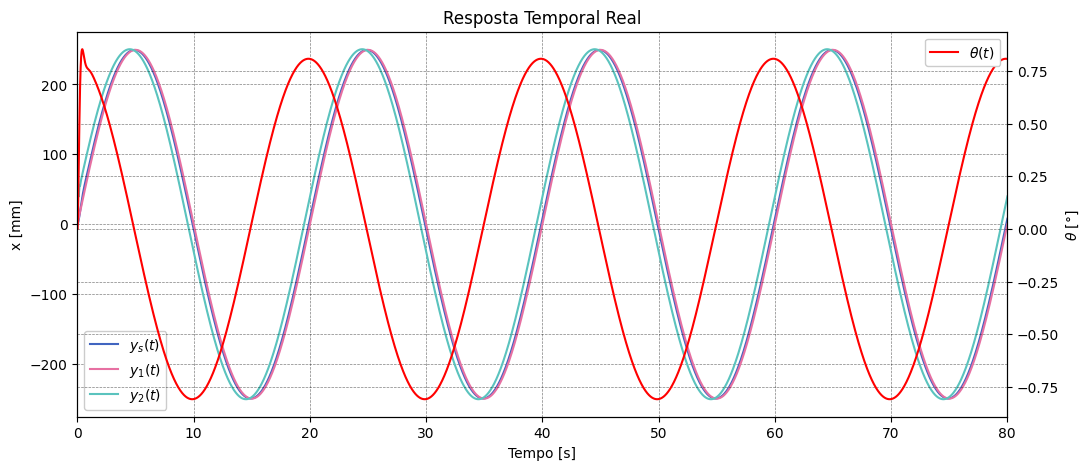

In [32]:
plt.rcParams['figure.figsize'] = (12, 5)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
labels = ['$y_s(t)$', '$\\theta(t)$', '$y_1(t)$', '$y_2(t)$']
for i in range(len(X)):
    if(i==1):
        ax2.plot(time, np.degrees(X[i]), color='red', label=labels[i])
    else:
        ax1.plot(time, (X[i]*1e3), label=labels[i])
ax1.set_ylabel('x [mm]')
ax2.set_ylabel('$\\theta$ [°]')
ax1.set_xlabel('Tempo [s]')
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')
plt.xlim(0, tf)
if(title):
    plt.title('Resposta Temporal Real')

plt.savefig('curves/TR2_MA.eps', dpi=600, transparent=True, bbox_inches='tight')

### Steady State:

In [33]:
XSS = XT
for a in preorder_traversal(XSS):
    if isinstance(a, type(exp(t))):
        XSS = XSS.subs(a, 0)

Matrix(arredNUM(XSS))

⎡0.2494⋅sin(0.3142⋅t) + 0.0063⋅cos(0.3142⋅t) ⎤
⎢                                            ⎥
⎢-0.0005⋅sin(0.3142⋅t) + 0.0141⋅cos(0.3142⋅t)⎥
⎢                                            ⎥
⎢0.2495⋅sin(0.3142⋅t) - 0.0013⋅cos(0.3142⋅t) ⎥
⎢                                            ⎥
⎣0.2475⋅sin(0.3142⋅t) + 0.0382⋅cos(0.3142⋅t) ⎦

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


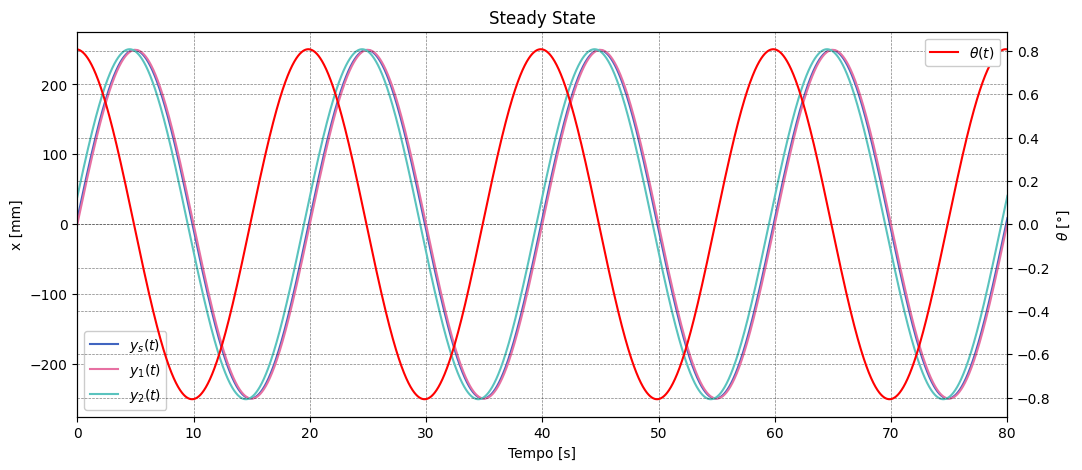

In [34]:
# Criando matriz de posição em função do tempo:

def const_function(time, cte):
    return ((time*0)+cte)


XSST = []
for i in XSS:
    fx = lambdify(t, i, 'numpy')
    css = fx(tf+time)
    if (isinstance(css, int)):
        for a in preorder_traversal(i):
            XSST.append(const_function(tf+time, a))
    else:
        XSST.append(css)

# Plotando os gráficos:
plt.rcParams['figure.figsize'] = (12, 5)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
labels = ['$y_s(t)$', '$\\theta(t)$', '$y_1(t)$', '$y_2(t)$']
for i in range(len(XSST)):
    if(i==1):
        ax2.plot(time, np.degrees(XSST[i]), color='red', label=labels[i])
    else:
        ax1.plot(time, (XSST[i]*1e3), label=labels[i])
ax1.set_ylabel('x [mm]')
ax2.set_ylabel('$\\theta$ [°]')
ax1.set_xlabel('Tempo [s]')
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')
plt.xlim(0, tf)
if(title):
    plt.title('Steady State')
plt.savefig('curves/steady_state.eps', dpi=600, transparent=True, bbox_inches='tight')

### Frequências naturais, em Hertz:

In [35]:
labels = ['s', 't', '1', '2']
for i in range(len(omega_n)):
    print(f'f{labels[i]} = {round((omega_n[i]/(2*np.pi)), 4)} Hz')

fs = 10.0219 Hz
ft = 8.4334 Hz
f1 = 1.1131 Hz
f2 = 1.4633 Hz


### Resposta em frequência:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


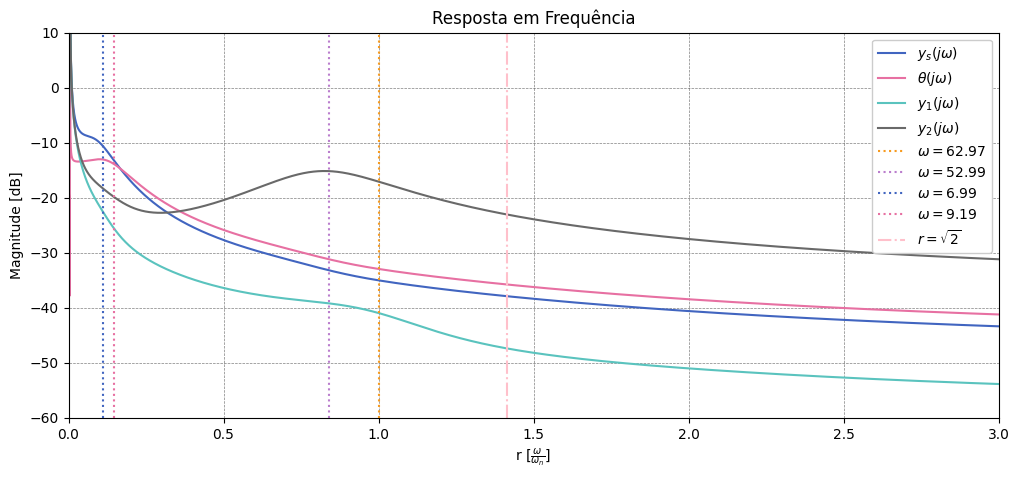

In [36]:
def mag2db(mag):
    return (20*np.log10(mag))

# Preparando as transformadas de Fourier:
def fft(sig, ts):
    freq = (np.fft.fftfreq(len(sig), ts)*2*np.pi)
    amp = mag2db(np.fft.fft(sig)[freq>0])
    phase = np.rad2deg(np.angle(np.fft.fft(sig)[freq>0]))
    freq = freq[freq>0]

    return freq, amp, phase

ffts = []
for i in X:
    ffts.append(fft(i, ts))

maxfreq = np.max(omega_n)

# Pltotando: Amplitude em função de frequência
plt.rcParams['figure.figsize'] = (12, 5)
plt.figure()
labels = ['$y_s(j\omega)$', '$\\theta(j\omega)$', '$y_1(j\omega)$', '$y_2(j\omega)$']
for i in range(len(ffts)):
    plt.plot((ffts[i][0]/maxfreq), ffts[i][1], label=labels[i])
for i in range(len(ffts)):
    plt.plot((omega_n[i]/maxfreq, omega_n[i]/maxfreq), (-60, 10), linestyle='dotted', label=f'$\omega = {omega_n[i]:.2f}$')
plt.plot((np.sqrt(2), np.sqrt(2)), (-60, 10), color='pink', linestyle='-.', label='$r = \sqrt{2}$')
plt.ylabel('Magnitude [dB]')
plt.legend()
plt.xlabel('r $[\\frac{\omega}{\omega_n}]$')
plt.xlim(0, 3)
plt.ylim(-60, 10)
if(title):
    plt.title('Resposta em Frequência')
plt.savefig('curves/FR_MA.eps', dpi=600, transparent=True, bbox_inches='tight')